In [ ]:
# default_exp find_peak

# Peak detection

In [ ]:
#hide
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
#%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# export
import numpy as np
import pandas as pd
from fastprogress.fastprogress import master_bar, progress_bar
from scipy.optimize import curve_fit
import os
import glob
from oco2peak import find_source

## Helper fonction

### Compute distance between two points with GPS coordinates.
Using haversine frmula.

In [ ]:
# export
def compute_haversine_formula(long, long_origin, lat, lat_origin, earth_radius=6367):
    """
    Function to compute Haversine formula from longitude, latitude, latitude origin and longitude
    origin
    :param earth_radius: int, indicating earth radius
    :param long: pandas Series, with longitude data of trace
    :param long_origin: pandas Series, with longitude origin of trace
    :param lat: pandas Series, with latitude data of trace
    :param lat_origin: pandas Series, with latitude origin of trace
    :return: pandas Series, with distance calculated from input using the Haversine formula
    """
    h = earth_radius * 2 * np.arcsin(np.sqrt(np.sin((np.radians(lat) - np.radians(lat_origin)) / 2) ** 2 +
                                             np.cos(np.radians(lat_origin)) * np.cos(np.radians(lat)) *
                                             np.sin((np.radians(long) - np.radians(long_origin)) / 2) ** 2))
    return h


### Compute distance of every point of a dataset

In [ ]:
# export
def compute_distance(df):
    orbit_long = df.groupby("orbit")["longitude"].first().rename("longitude_orig")
    orbit_lat = df.groupby("orbit")["latitude"].first().rename("latitude_orig")
    df = pd.concat([df.set_index("orbit"), orbit_lat, orbit_long], axis=1).reset_index()
    # data_1808_25["distance"] = data_1808_25.apply(lambda df: compute_haversine_formula(df["longitude"],
    #                                                                                    df["longitude_orig"],
    #                                                                                    df["latitude"],
    #                                                                                    df["latitude_orig"]),
    #                                               axis=1)
    df["distance"] = compute_haversine_formula(df["longitude"], df["longitude_orig"], df["latitude"],
                                               df["latitude_orig"])
    df = df.sort_values(by=['orbit', 'distance']).reindex()
    return df

### Load a dataset

In [ ]:
#export
def load_data(file):
    data = pd.read_csv(file, sep=";")
    data = compute_distance(data)
    return data

### Gaussian function
With support line orientation.

In [ ]:
# export
def gaussian(x, m, b, A, sig):
    """
    Function used to fit gaussian in peak_detection
    :param x: float, input data for curve
    :param m: float, slope of the data
    :param b: float, intercept of the data
    :param A: float, curve amplitude
    :param sig: float, standard deviation of curve
    :return: float
    """
    return m * x + b + A / (sig * (2 * np.pi) ** 0.5) * np.exp(-x ** 2 / (2 * sig ** 2))

## Peak detection

In [ ]:
#export
def peak_detection(df_orbit, orbit_number, orbit_index, output_dir, implement_filters, window=200,
                   output_peak=True):
    """
    Function to determine peak from orbit, with option to implement Frederic Chevallier filters or not
    to restrict peaks found
    Gaussian Fit based on
    scipy.optimize.curve_fit
    scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=default_return, check_finite=True,
    bounds=(-inf, inf), method=None, jac=None, **kwargs)[source], where :
    p0 = Initial guess for the parameters (length N).
    sigma : Determines the uncertainty in ydata.
    ftol=0.5, xtol=0.5 to speed up
    :param window: int, parameter to indicate window in km to compute the trace for each potential peak
    :param df_orbit: pandas DataFrame
    :param orbit_number: int, orbit value corresponding to orbit_index
    :param orbit_index: int, index in input data for orbit data
    :param output_dir: str, directory to store json files for peaks
    :param implement_filters: Boolean, if True filters are applied to filter out
    peaks judged insufficiently good
    :param output_peak: Boolean, if True, outputs the data around peak to json in specified path
    :return:
    """
    default_return = {}
    km_start = df_orbit.loc[orbit_index, 'distance']
    # Slice back because our input point is the middle of the peak
    df_slice = df_orbit.query('distance >= (@km_start-@window/2) and distance <= (@km_start + @window/2)').copy()
    # Skip if too few data
    if len(df_slice) < 400:
        return default_return
    med_temp = np.median(df_slice['xco2'])
    df_slice['xco2_enhancement'] = df_slice['xco2'] - med_temp

    # Base parameters for : m, b, A, sig
    p0 = (0., med_temp, 30 * df_slice.loc[orbit_index, 'xco2_enhancement'], 10.)
    d_centered = df_slice['distance'] - km_start
    popt, _ = curve_fit(f=gaussian, xdata=d_centered, ydata=df_slice['xco2'], sigma=df_slice['xco2_uncert'], p0=p0,
                        maxfev=20000, ftol=0.5, xtol=0.5)
    sig = abs(popt[3])  # sigma of the Gaussian (km)
    delta = popt[2] / (popt[3] * (2 * np.pi) ** 0.5)  # height of the peak (ppm)

    if implement_filters:
        if sig < 2:
            return default_return  # too narrow
        if 3 * sig > window / 2.:
            return default_return  # too large
        if delta < 0:
            return default_return  # depletion
        if len(df_slice[(d_centered >= -1 * sig) & (d_centered <= 0)]) < int(sig):
            return default_return
        if len(df_slice[(d_centered <= 1 * sig) & (d_centered >= 0)]) < int(sig):
            return default_return
        if len(df_slice[(d_centered >= -3 * sig) & (d_centered <= -2 * sig)]) < int(sig):
            return default_return
        if len(df_slice[(d_centered <= 3 * sig) & (d_centered >= 2 * sig)]) < int(sig):
            return default_return

    # measure the quality of the fit
    d_peak = df_slice[(d_centered >= -4 * sig) & (d_centered <= 4 * sig)]
    d_peak_distance = d_peak['distance'] - df_slice.loc[orbit_index, 'distance']
    R = np.corrcoef(gaussian(d_peak_distance, *popt), d_peak['xco2'])
    if implement_filters:
        if R[0, 1] ** 2 < 0.25:
            return default_return
        if R[0, 1] < 0.00:
            return default_return # The correlation must be positive
    peak = {
        'sounding_id': df_slice.loc[orbit_index, 'sounding_id'],
        'latitude': df_slice.loc[orbit_index, 'latitude'],
        'longitude': df_slice.loc[orbit_index, 'longitude'],
        'orbit': orbit_number,
        'slope': popt[0],
        'intercept': popt[1],
        'amplitude': popt[2],
        'sigma': popt[3],
        'delta': delta,
        'R': R[0, 1],
        'windspeed_u': df_slice.loc[orbit_index, 'windspeed_u'],
        'windspeed_v': df_slice.loc[orbit_index, 'windspeed_v'],
        'surface_pressure': df_slice.loc[orbit_index, 'surface_pressure'],
        'tcwv': df_slice.loc[orbit_index, 'tcwv'],
    }
    emission = find_source.estimate_emission(df_slice, peak)
    peak['gCO2_per_s'] = emission['gCO2_per_s']
    peak['ktCO2_per_h'] = emission['ktCO2_per_h']
    # Save sounding data around peak
    if output_peak:
        df_slice['distance'] = df_slice['distance'] - df_orbit.loc[orbit_index, 'distance']
        filename = 'peak_data-si_' + str(df_slice.loc[orbit_index, 'sounding_id']) + '.json'
        df_slice.to_json(os.path.join(output_dir, filename), orient='records')
    return peak

## Iterate over satellite orbits

In [ ]:
#export
def gaussian_fit_on_df(df_full, input_name='', output_dir='', output_peak=True, implement_filters=True,
                       output_csv=True, master_progress_bar = None):
    """
    Function used to apply peak_detection to oco2 data
    :param output_csv: Boolean, if True, outputs csv with peaks all peaks detected
    :param implement_filters: Boolean, if True, implements Frederic Chevallier filters on peak detection
    :param output_peak: Boolean, if True outputs peak data to different json files
    :param df_full: pandas DataFrame, containing information for one or several orbits
    :param input_name: str, not implemented for now
    :param output_dir: str, directory for output data
    :param master_bar: MasterBar object to display global progress bar
    :return: list of dictionaries, where each element of list is peak data contained in a dictionary (returned value
    of peak_detection)
    """
    peak_found_number = 0
    peak_founds = []
    if master_progress_bar is None:
        master_progress_bar = master_bar(df_full['orbit'].unique())
        orbits = master_progress_bar
        with_master_progress_bar = True
    else:
        orbits = progress_bar(df_full['orbit'].unique(), parent=master_progress_bar)
        with_master_progress_bar = False
    for orbit in orbits:
        df_orbit = df_full[df_full['orbit'] == orbit].copy()
        if len(df_orbit) < 500:
            continue
        # Loop over the sounding id's
        if with_master_progress_bar:
            soundings = progress_bar(df_orbit.index, parent=master_progress_bar)
        else :
            soundings = df_orbit.index
        for i, orbit_index in enumerate(soundings):
            try:
                # Work only each n soundings (15 seems good)
                if i % 15 != 0:  # perhaps implement random sample instead of fixed param
                    continue
                peak = peak_detection(df_orbit, orbit, orbit_index, output_dir, implement_filters=implement_filters,
                                      window=200, output_peak=output_peak)
                if peak:
                    peak_found_number += 1
                    peak_founds.append(peak)
            except RuntimeError:
                master_progress_bar.write(f'WARNING : Failed for orbit {orbit} and index {orbit_index}')
    if peak_found_number == 0:
        master_progress_bar.write(f'No peak found in {input_name}')
    elif output_csv:
        # Save at every orbit, but with same name because we do not empty peak_founds
        filename = 'result_for_' + input_name + '.csv'
        master_progress_bar.write(f'Saving to :  {os.path.join(output_dir, filename)}')
        df = pd.DataFrame(peak_founds)
        df.to_csv(os.path.join(output_dir, filename), sep=';')
        peak_found_number = 0
    return peak_founds


# Example

## Load some test data

In [ ]:
from oco2peak.datasets import Datasets
config = './configs/config.json'
datasets = Datasets(config)
# df = load_data('/media/data-nvme/dev/datasets/OCO2/csv-v10/oco2_1608.csv')
# df.head(3)
url=datasets.get_files_urls('soudings/oco2_1608.')[0]
print(url)
df=load_data(url)

https://storage.gra.cloud.ovh.net/v1/AUTH_2aaacef8e88a4ca897bb93b984bd04dd/oco2//datasets/oco-2/soudings/oco2_1608.csv.xz


In [ ]:
df_tmp = df[df.orbit.isin([11522,11460])]
df_tmp.to_csv(os.path.join('../dataset/', 'oco2_1608-sample.csv'), sep=';')

In [ ]:
df_11522 = df[df.orbit == 11522].copy()
del(df)
if 'tcwv' not in df_11522.columns:
    df_11522['tcwv'] = 25
df_11522.head(3)

,orbit,sounding_id,latitude,longitude,xco2,xco2_uncert,windspeed_u,windspeed_v,surface_pressure_apriori,surface_pressure,altitude,land_water_indicator,land_fraction,latitude_orig,longitude_orig,distance,tcwv
2045711,11522,2016083111543978,-31.099339,30.151365,404.383850,0.613275,-5.619052,-6.025066,1004.184204,998.226868,91.858063,0.0,100.0,-31.099339,30.151365,0.000000,25
2045713,11522,2016083111544008,-31.079346,30.146057,403.257385,0.623100,-5.533184,-5.928918,997.343323,991.352661,152.098557,0.0,100.0,-31.099339,30.151365,2.278408,25
2045712,11522,2016083111544007,-31.079248,30.159698,403.593414,0.623099,-5.583017,-5.997904,999.478088,993.871216,133.584885,0.0,100.0,-31.099339,30.151365,2.369177,25


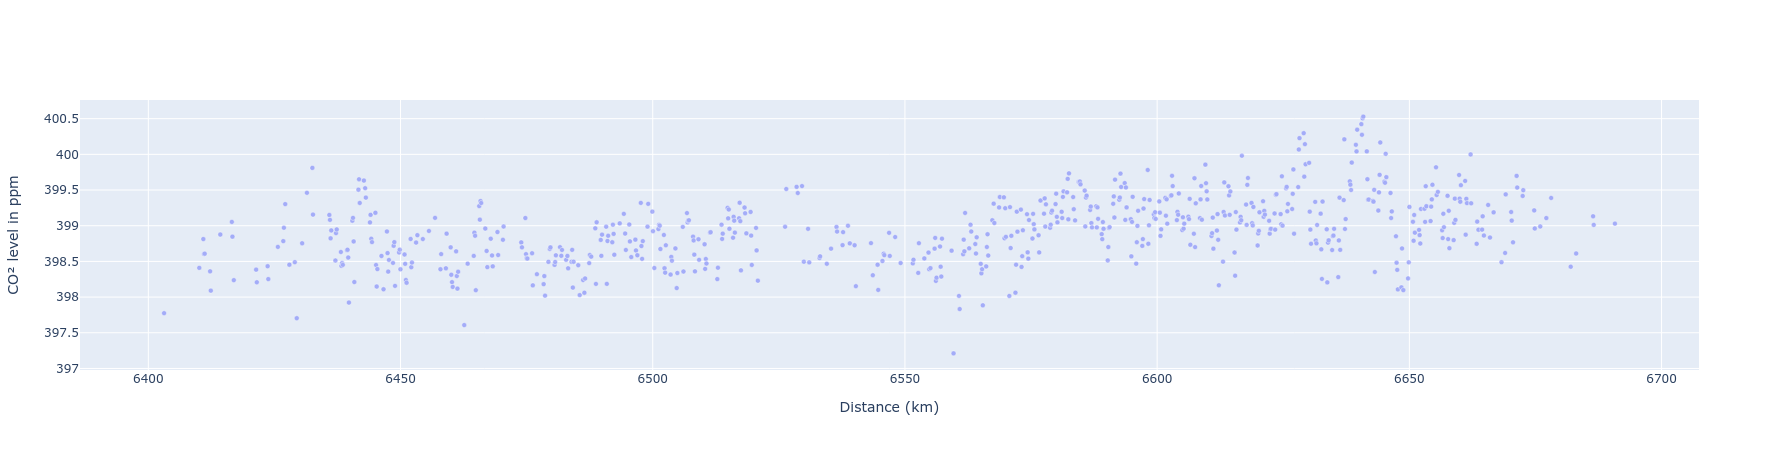

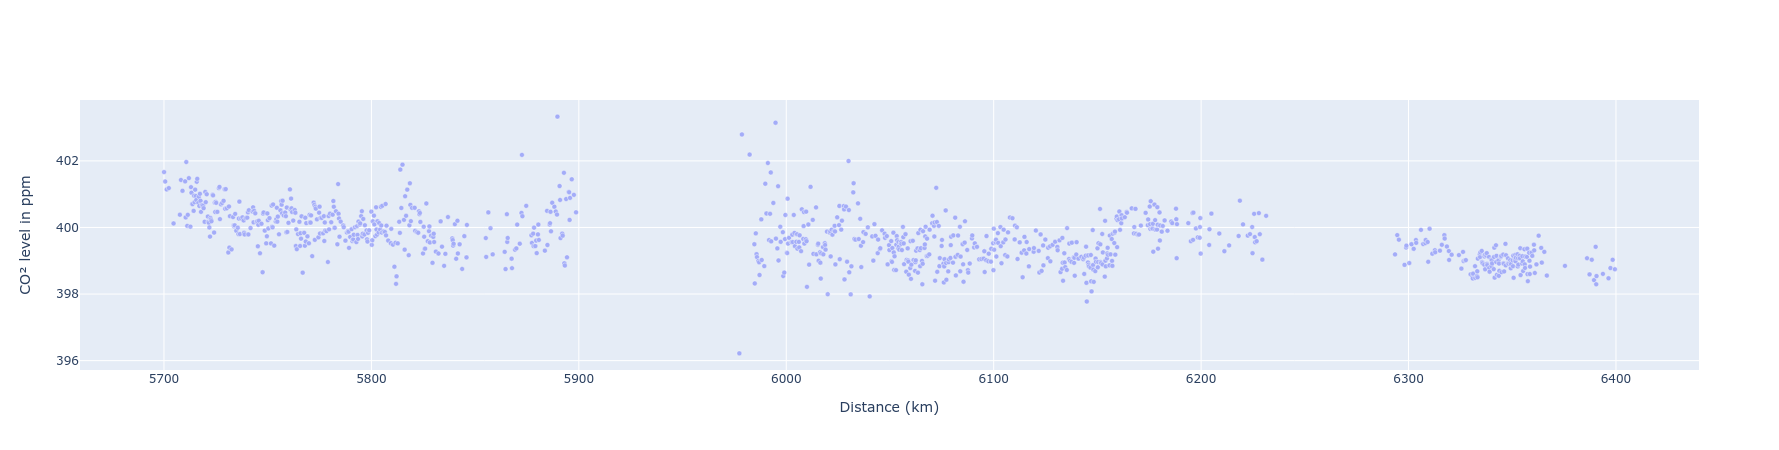

In [ ]:
from oco2peak import oco2map
import plotly.io as pio

gaussian_param = {'slope' : 1,'intercept' : 1,'amplitude' : 1,'sigma': 1,'delta': 1,'R' : 1}
df_11522['gaussian_y']=0
df_6400 = df_11522.query("distance > 6400 and distance < 6700")
sounding_scatter1 = oco2map.build_sounding_scatter(df_6400, gaussian_param, plot_gaussian = False)
pio.show(sounding_scatter1)
df_5700 = df_11522.query("distance > 5700 and distance < 6400")
sounding_scatter2 = oco2map.build_sounding_scatter(df_5700, gaussian_param, plot_gaussian = False)
pio.show(sounding_scatter2)

In [ ]:
# df_6400
peaks_found = gaussian_fit_on_df(df_11522, input_name='oco2_1608', output_dir='../datasets', output_peak=False,
                                     output_csv=False, implement_filters=True)


In [ ]:
df = pd.DataFrame(peaks_found)
df

,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v,surface_pressure,tcwv,gCO2_per_s,ktCO2_per_h
0,2016083111551503,-28.978931,29.665262,11522,0.006731,402.787208,3.317424,11.770196,0.112442,0.538051,1.180701,-3.198607,890.582397,25,1.623350e+04,0.058441
1,2016083111551707,-28.860731,29.581593,11522,0.006889,402.709366,20.311899,16.584199,0.488614,0.550827,1.594114,-2.801351,901.318481,25,2.404239e+05,0.865526
2,2016083111551872,-28.758278,29.622032,11522,0.005812,402.738850,23.454376,19.484713,0.480220,0.542872,1.720806,-2.545571,904.103516,25,3.391184e+05,1.220826
3,2016083111555103,-26.817226,29.116753,11522,0.021030,404.532054,14.315780,12.064666,0.473380,0.556092,-0.501652,-0.667103,846.891846,25,1.213156e+05,0.436736
4,2016083111555436,-26.618835,29.027727,11522,0.008319,404.426337,30.783919,7.513463,1.634533,0.512225,-1.167906,-0.825887,853.898804,25,5.415509e+05,1.949583
5,2016083111560007,-26.278584,28.930351,11522,-0.011592,403.773000,137.961788,12.884591,4.271675,0.651485,-1.699455,-1.599629,848.299805,25,3.681855e+06,13.254680
6,2016083111560104,-26.216522,28.953884,11522,-0.014004,403.663792,163.444639,30.331834,2.149721,0.766822,-1.767803,-1.788595,849.444275,25,4.606008e+06,16.581630
7,2016083111560201,-26.153618,28.977415,11522,-0.016627,403.712532,142.158823,18.798734,3.016861,0.795819,-1.831899,-1.976279,848.736755,25,4.203441e+06,15.132387
8,2016083111560301,-26.093527,28.962337,11522,-0.019264,403.858951,98.280306,12.110245,3.237603,0.604548,-1.867593,-2.162038,844.733826,25,2.993425e+06,10.776331
9,2016083111560373,-26.055502,28.926592,11522,-0.020756,403.907591,75.045441,18.526312,1.616015,0.747881,-1.878785,-2.289192,851.559265,25,2.344304e+06,8.439496


In [ ]:
for peak in peaks_found:
    sounding_id = peak['sounding_id']
    print(peak['sounding_id'], peak['delta'])
    #print()
    df_peak = df_11522.query("sounding_id == @sounding_id")
    if sounding_id == 2016083111560007:
        df_best_peak = df_peak
        df_best_peak.head(3)
        print(peak)
        gaussian_param = peak

2016083111551503 0.11244169571533527
2016083111551707 0.4886141916298467
2016083111551872 0.48021965621270424
2016083111555103 0.4733798642344435
2016083111555436 1.634533453597039
2016083111560007 4.271675238318846


,orbit,sounding_id,latitude,longitude,xco2,xco2_uncert,windspeed_u,windspeed_v,surface_pressure_apriori,surface_pressure,altitude,land_water_indicator,land_fraction,latitude_orig,longitude_orig,distance,tcwv,gaussian_y
2047271,11522,2016083111560007,-26.278584,28.930351,408.74408,0.689968,-1.699455,-1.599629,845.875061,848.299805,1603.824097,0.0,100.0,-31.099339,30.151365,548.756503,25,0


{'sounding_id': 2016083111560007, 'latitude': -26.278583526611328, 'longitude': 28.93035125732422, 'orbit': 11522, 'slope': -0.01159189873678292, 'intercept': 403.77299983936456, 'amplitude': 137.96178820994956, 'sigma': 12.884591483691011, 'delta': 4.271675238318846, 'R': 0.6514848826125377, 'windspeed_u': -1.6994545459747314, 'windspeed_v': -1.5996288061141968, 'surface_pressure': 848.2998046875, 'tcwv': 25, 'gCO2_per_s': 3681855.4767211988, 'ktCO2_per_h': 13.254679716196316}
2016083111560104 2.1497208540689674
2016083111560201 3.0168608484076995
2016083111560301 3.237603425796474
2016083111560373 1.6160150291083462
2016083111560435 1.068382711496507
2016083111581301 0.25019563391129923
2016083111581507 0.16951190808336303
2016083111581635 0.09287377230092317
2016083111581705 0.05126048347062962
2016083111583177 0.02129701749996721


548.7565031286568

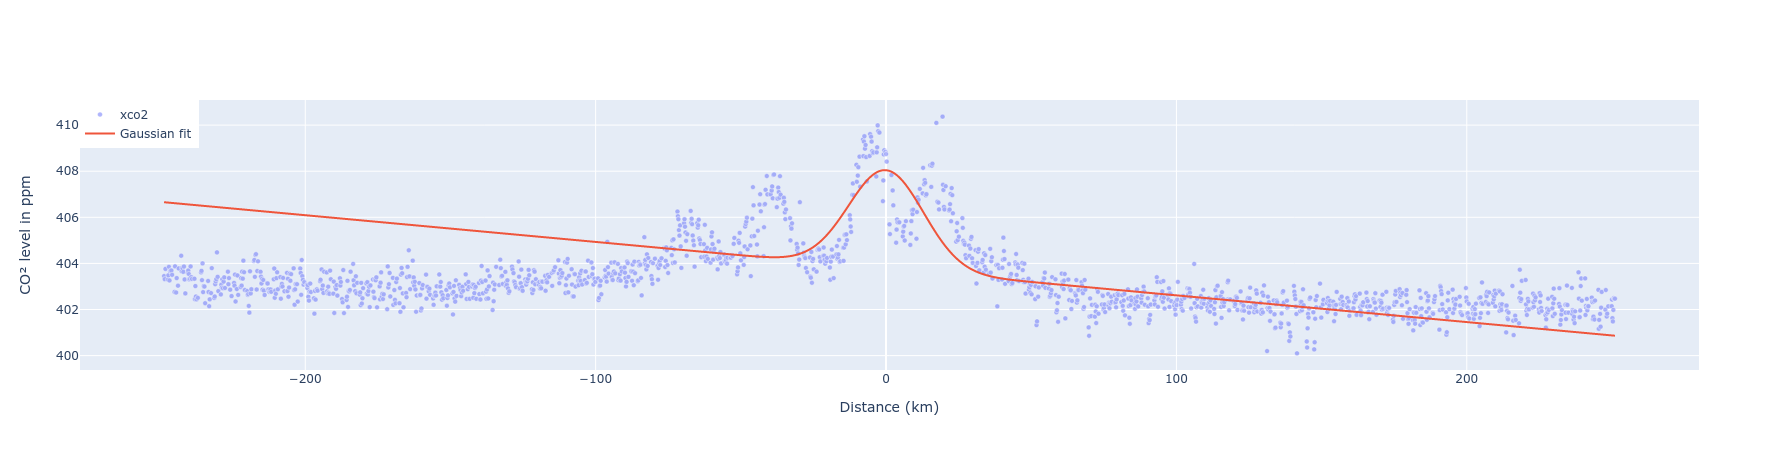

In [ ]:
distance = df_best_peak.iloc[0]['distance']
distance
begin = distance - 100
end = distance + 100
# gaussian_param
# df_peak = df_11522.query("distance > @begin and distance < @end")
# df_peak.distance = df_peak.distance - distance
# df_peak['gaussian_y'] = df_peak.distance.apply(
#     lambda x: gaussian(x=x, m=gaussian_param['slope'], b=gaussian_param['intercept'], A=gaussian_param['amplitude'], sig=gaussian_param['sigma']))
# sounding_plot = oco2map.build_sounding_scatter(df_peak, gaussian_param, plot_gaussian = True)
# pio.show(sounding_plot)

df_peak = df_11522.query("distance > 300 and distance < 800").copy()
df_peak.distance = df_peak.distance - distance
df_peak['gaussian_y'] = df_peak.distance.apply(
    lambda x: gaussian(x=x, m=gaussian_param['slope'], b=gaussian_param['intercept'], A=gaussian_param['amplitude'], sig=gaussian_param['sigma']))

sounding_plot = oco2map.build_sounding_scatter(df_peak, gaussian_param, plot_gaussian = True)
pio.show(sounding_plot)

In [ ]:
# export
def gaussian_fit_on_file(file, output_dir, master_progress_bar):
    year_month = file[file.find('oco2_')+5 : file.find('.csv')]
    #master_progress_bar.write(f'Processing {file}, for {year_month}')
    df = load_data(file)
    gaussian_fit_on_df(df, input_name='oco2_'+year_month, output_dir=output_dir, output_peak=True,
                                     output_csv=True, implement_filters=True, master_progress_bar=master_progress_bar)

# Processing all files in a directory

In [ ]:
input_dir  = r'/media/data-nvme/dev/datasets/OCO2/csv'
output_dir = r'/media/data-nvme/dev/datasets/OCO2/peak-v9/'

master_progress_bar = master_bar(glob.glob(input_dir + "/oco2_1709*", recursive=False))
for file in master_progress_bar:
    #gaussian_fit_on_file(file, output_dir, master_progress_bar)
    None

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 03_25_OCO2_Data_Exploration.ipynb.
Converted 04_01_OCO2_Work_Base.ipynb.
Converted 04_04_OCO2_China_Peaks.ipynb.
Converted 04_15_OCO2_Laiwu_Peak_Detection.ipynb.
Converted CO2_emissions_Inventory_data.ipynb.
Converted Christian-datasets-Distances.ipynb.
Converted Find_Peaks_with_LSTM_autoencoders.ipynb.
Converted Laiwu_Plume-more_data.ipynb.
Converted Laiwu_Plume-more_data_CD_exploration_selection_peaks.ipynb.
Converted Laiwu_Plume.ipynb.
Converted Untitled.ipynb.
Converted WIP_OCO2_Capture.ipynb.
Converted WIP_OCO2_Peaks_Wind.ipynb.
Converted WIP_OCO2_Peaks_Wind_Visualization.ipynb.
Converted find_peak_bco_test.ipynb.
Converted index.ipynb.
Converted oco2peak-datasets.ipynb.
Converted oco2peak-find_peak.ipynb.
Converted oco2peak-map.ipynb.
Converted oco2peak-nc4_convert.ipynb.
Converted oco2peak-swift_utils.ipynb.
Converted oco2peak_find_source.ipynb.
Converted show_map.ipynb.
Converted view_peak.ipynb.
